# Fine tuning of Random Forest Classifier model

## for binary classification

In [1]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.ensemble import RandomForestClassifier

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [3]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
# kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

### Tuning without PCA

In [9]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = RandomForestClassifier(random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(
        estimator, param_grid, 
        factor=2, 
        cv=kf, 
        scoring=scorer, 
        refit=True, 
        verbose=1, 
        resource='model__n_estimators',
        max_resources=500
    )
    search.fit(X_train, y_train)
        
    return search

In [38]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(
        subset=[
            'param_model__criterion', 
            'param_model__max_depth',
            'param_model__max_features',
            'param_model__n_estimators', 
            'param_model__min_samples_split'
        ], 
        keep='last'
    )
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for crit in df['param_model__criterion'].unique():
        for md in df['param_model__max_depth'].unique():
            for mf in df['param_model__max_features'].unique():
                print(f'criterion = {crit}  max_depth = {md}  max_features = {mf}')
                
                df_p = df[(df['param_model__criterion'] == crit) & (df['param_model__max_depth'] == md) & (df['param_model__max_features'] == mf)]
                data = df_p.pivot_table(index='param_model__min_samples_split', columns='param_model__n_estimators', values='mean_test_score', aggfunc=np.max, fill_value=0)
                annot = df_p.pivot_table(index='param_model__min_samples_split', columns='param_model__n_estimators', values='rank', aggfunc=np.min, fill_value=0)    

                sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
                plt.show()

                # try:
                #     sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
                #     plt.show()
                # except:
                #     pass

In [10]:
param_grid = {
    'model__criterion': ['gini'],       # , 'entropy', 'log_loss'
    'model__max_depth': [2, 4, 6, 8, 10],
    'model__max_features': ['sqrt'],    # , 'log2'
    'model__min_samples_split': [2, 4, 8, 16, 32],
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 31
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 25
n_resources: 31
Fitting 50 folds for each of 25 candidates, totalling 1250 fits
----------
iter: 1
n_candidates: 13
n_resources: 62
Fitting 50 folds for each of 13 candidates, totalling 650 fits
----------
iter: 2
n_candidates: 7
n_resources: 124
Fitting 50 folds for each of 7 candidates, totalling 350 fits
----------
iter: 3
n_candidates: 4
n_resources: 248
Fitting 50 folds for each of 4 candidates, totalling 200 fits
----------
iter: 4
n_candidates: 2
n_resources: 496
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__criterion': 'gini', 'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 496}

Best score:
0.9988250003208416

criterion = gini  max_depth = 8  max_features = sqrt


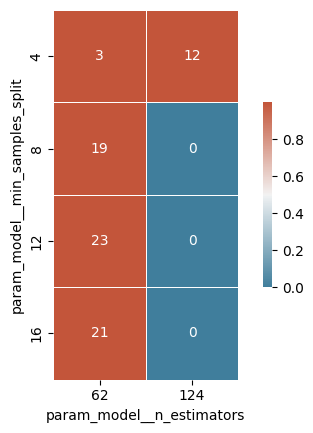

criterion = gini  max_depth = 10  max_features = sqrt


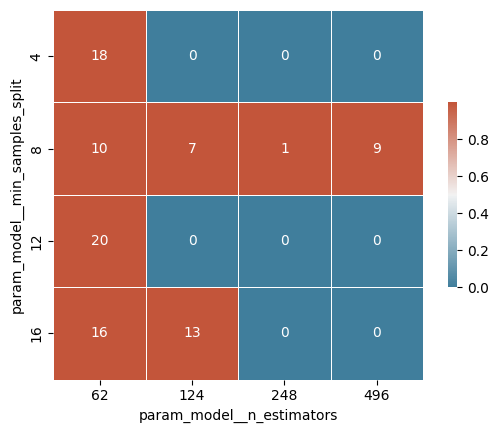

criterion = gini  max_depth = 12  max_features = sqrt


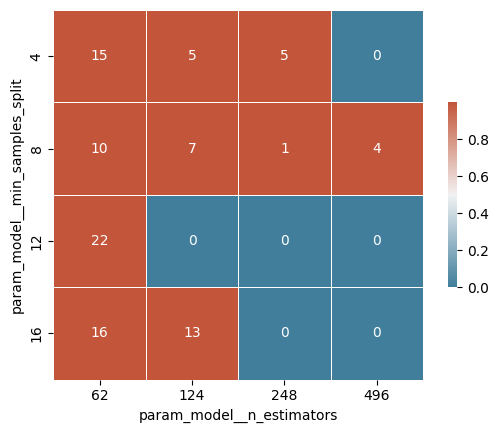

In [40]:
report_results(results)

### Fine-tuning for the most promising region

In [41]:
param_grid = {
    'model__criterion': ['gini'],       # , 'entropy', 'log_loss'
    'model__max_depth': [10, 12, 14, 16],
    'model__max_features': ['sqrt'],    # , 'log2'
    'model__min_samples_split': [6, 7, 8, 9, 10],
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 31
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 20
n_resources: 31
Fitting 50 folds for each of 20 candidates, totalling 1000 fits
----------
iter: 1
n_candidates: 10
n_resources: 62
Fitting 50 folds for each of 10 candidates, totalling 500 fits
----------
iter: 2
n_candidates: 5
n_resources: 124
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 3
n_candidates: 3
n_resources: 248
Fitting 50 folds for each of 3 candidates, totalling 150 fits
----------
iter: 4
n_candidates: 2
n_resources: 496
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__criterion': 'gini', 'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 496}

Best score:
0.9988250003208416

criterion = gini  max_depth = 10  max_features = sqrt


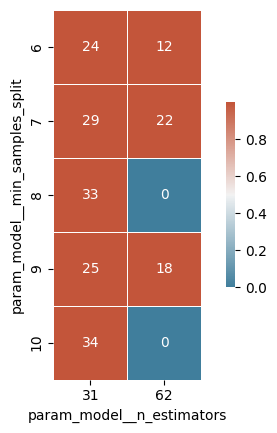

criterion = gini  max_depth = 12  max_features = sqrt


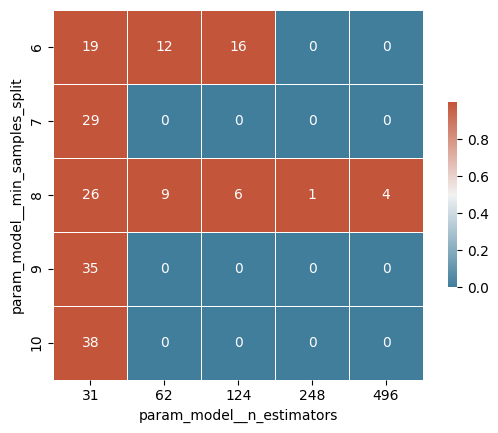

criterion = gini  max_depth = 14  max_features = sqrt


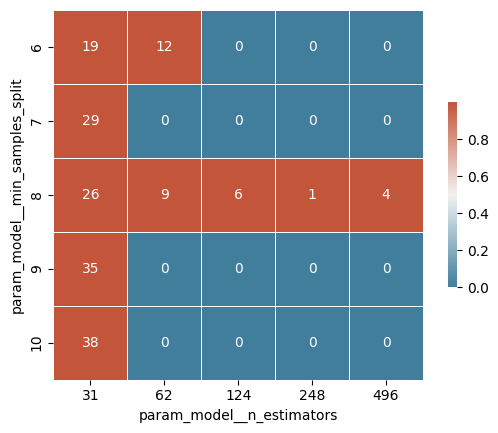

criterion = gini  max_depth = 16  max_features = sqrt


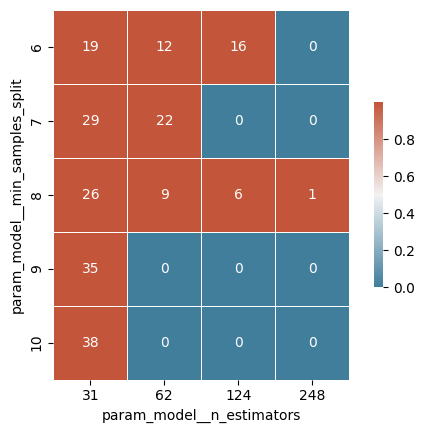

In [42]:
report_results(results)

### Fine-tuning for the most promising region

In [43]:
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [12, 13, 14],
    'model__max_features': ['sqrt', 'log2'],
    'model__min_samples_split': [7, 8, 9],
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 15
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 54
n_resources: 15
Fitting 50 folds for each of 54 candidates, totalling 2700 fits
----------
iter: 1
n_candidates: 27
n_resources: 30
Fitting 50 folds for each of 27 candidates, totalling 1350 fits
----------
iter: 2
n_candidates: 14
n_resources: 60
Fitting 50 folds for each of 14 candidates, totalling 700 fits
----------
iter: 3
n_candidates: 7
n_resources: 120
Fitting 50 folds for each of 7 candidates, totalling 350 fits
----------
iter: 4
n_candidates: 4
n_resources: 240
Fitting 50 folds for each of 4 candidates, totalling 200 fits
----------
iter: 5
n_candidates: 2
n_resources: 480
Fitting 50 folds for each of 2 candidates, totalling 100 fits


Best parameters:
{'model__criterion': 'gini', 'model__max_depth': 12, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 480}

Best score:
0.9988250003208416

criterion = gini  max_depth = 12  max_features = sqrt


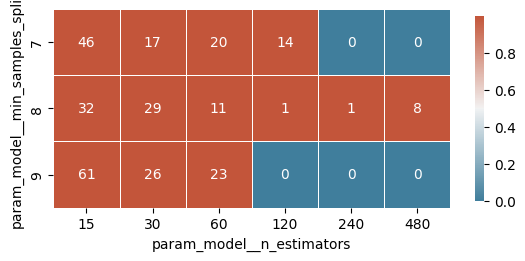

criterion = gini  max_depth = 12  max_features = log2


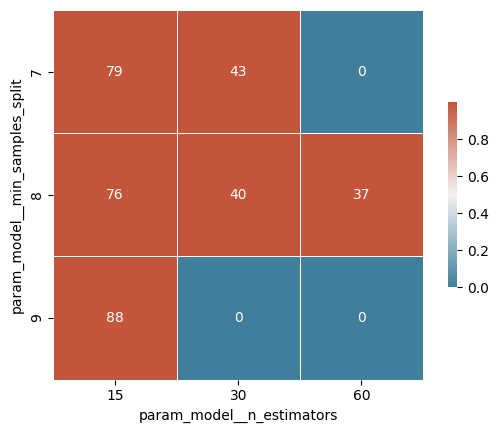

criterion = gini  max_depth = 13  max_features = sqrt


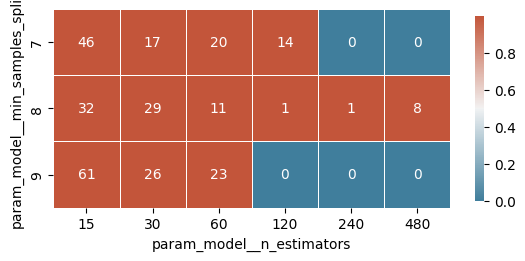

criterion = gini  max_depth = 13  max_features = log2


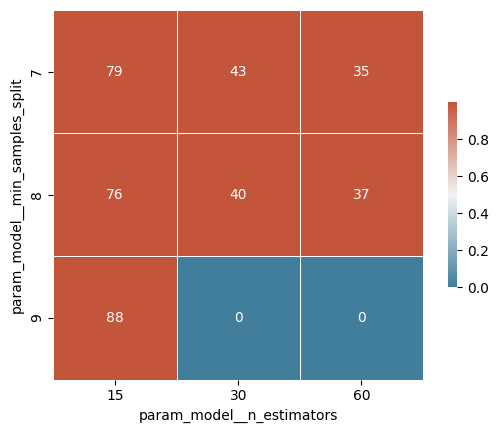

criterion = gini  max_depth = 14  max_features = sqrt


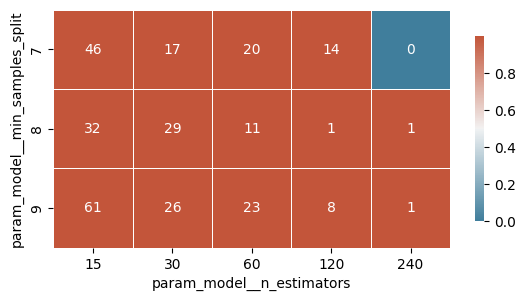

criterion = gini  max_depth = 14  max_features = log2


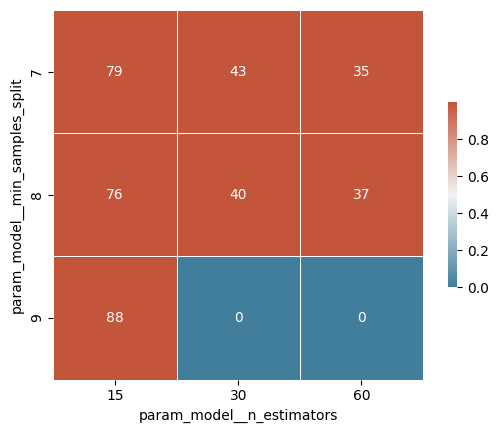

criterion = entropy  max_depth = 12  max_features = sqrt


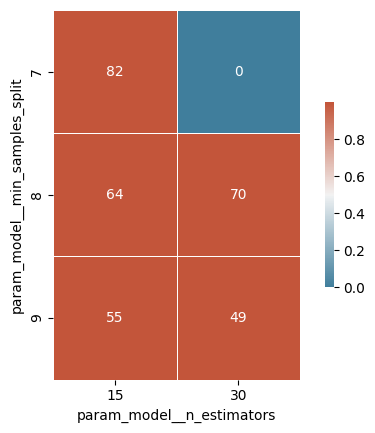

criterion = entropy  max_depth = 12  max_features = log2


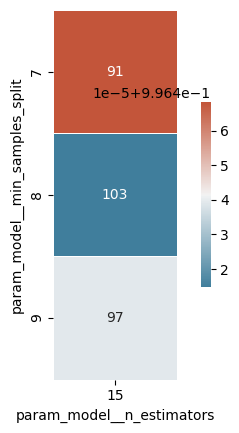

criterion = entropy  max_depth = 13  max_features = sqrt


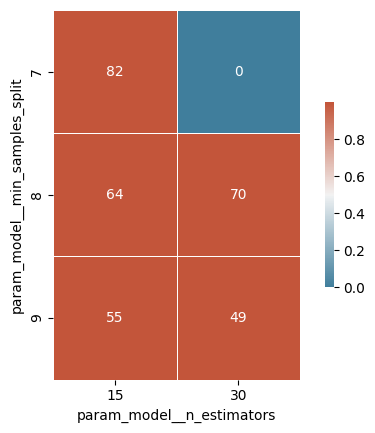

criterion = entropy  max_depth = 13  max_features = log2


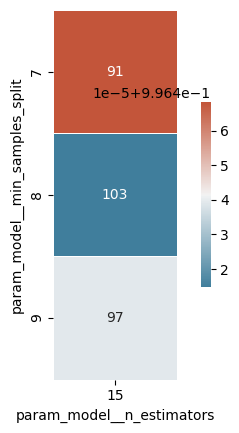

criterion = entropy  max_depth = 14  max_features = sqrt


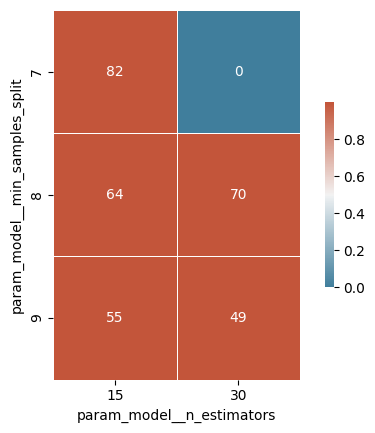

criterion = entropy  max_depth = 14  max_features = log2


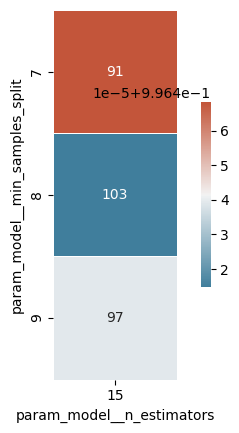

criterion = log_loss  max_depth = 12  max_features = sqrt


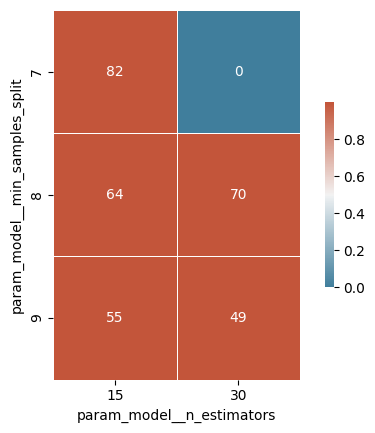

criterion = log_loss  max_depth = 12  max_features = log2


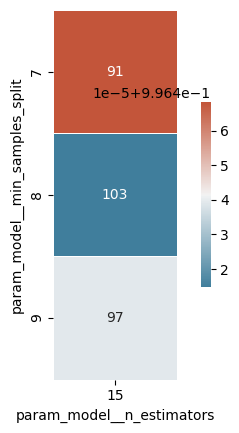

criterion = log_loss  max_depth = 13  max_features = sqrt


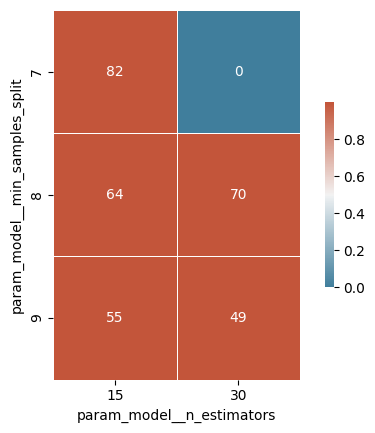

criterion = log_loss  max_depth = 13  max_features = log2


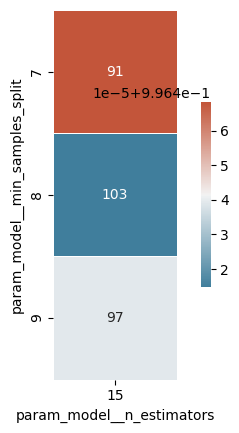

criterion = log_loss  max_depth = 14  max_features = sqrt


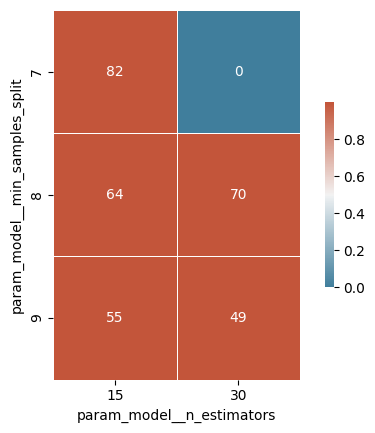

criterion = log_loss  max_depth = 14  max_features = log2


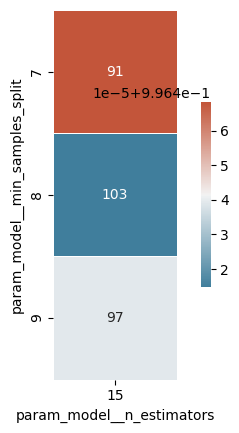

In [44]:
report_results(results)

## Best model cross-validation performance

In [45]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9988
Median: 1.0000
95% confidence interval: (0.9947 - 1.0000)


## Evaluate best model on hold-out test dataset

In [46]:
y_pred = results.best_estimator_.predict(X_test)

In [47]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     1.0000    0.9974    0.9987       380

    accuracy                         0.9995      2026
   macro avg     0.9997    0.9987    0.9992      2026
weighted avg     0.9995    0.9995    0.9995      2026



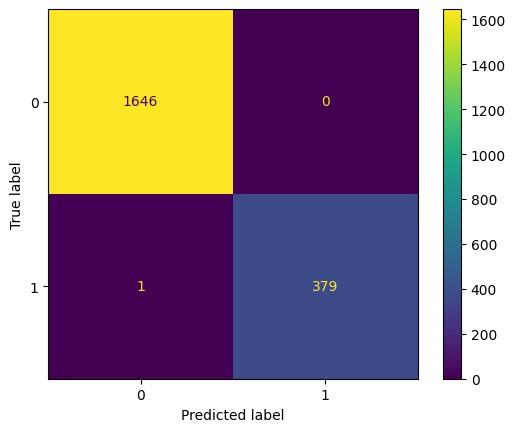

In [48]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

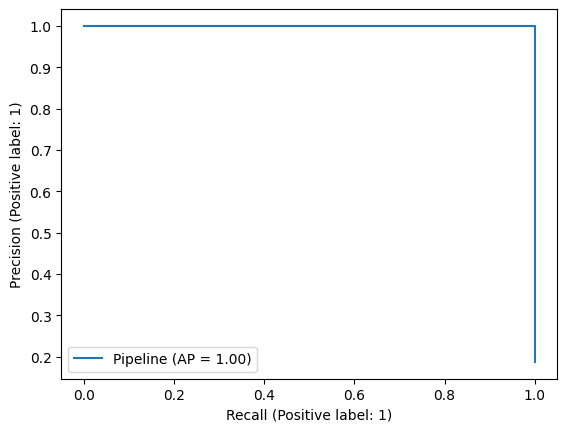

In [49]:
# Precision - Recall curve
PrecisionRecallDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

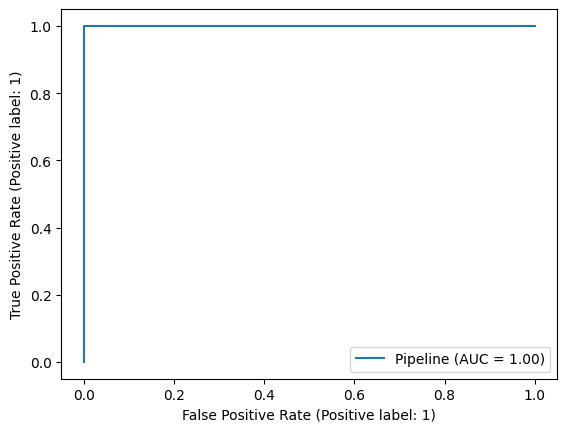

In [50]:
# ROC curve
RocCurveDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()